In [2]:
using Serialization

In [3]:
sols = deserialize("scan_2frequences.jl")

LoadError: KeyError: key SciMLBase [0bca4576-84f4-4d90-8ffe-ffa030f20462] not found

In [1]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations, 
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_2frequencies.jl")
working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan\\scan_2frequencies"
;

In [2]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if times[i][end] * 1e-3 ≈ t_end
            push!(_survived, i)
        end
    end
    return _survived
end

function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end

"""
    Evaluates how many particles are within a 0.3 mm radius.
"""
function goodness(t_end, sols, scan_values, scan_values_grid)
    
    sols_values = get_sols_from_values(sols, scan_values, scan_values_grid)

    all_trajectories = [trajectories(sol) for sol ∈ sols_values]
    all_x_trajectories = [traj[1] for traj ∈ all_trajectories]
    all_y_trajectories = [traj[2] for traj ∈ all_trajectories]
    all_z_trajectories = [traj[3] for traj ∈ all_trajectories]

    times = [sol.t ./ (Γ * 1e-3) for sol ∈ sols_values]
    n_molecules = length(times)
    
    _survived = survived(t_end, times, all_x_trajectories)
    
    surviving_x_trajectories = all_x_trajectories[_survived]
    surviving_y_trajectories = all_y_trajectories[_survived]
    surviving_z_trajectories = all_z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(all_x_trajectories[survived_idx])
        if distance(all_x_trajectories[survived_idx], all_y_trajectories[survived_idx], all_z_trajectories[survived_idx], idx_end) < 0.3
            n += 1
        end
    end
    return n
end
;

### Set up the molecule

In [3]:
package = get_CaOH_package()
n_states = length(package.states)
n_excited = package.n_excited
;

In [4]:
"""
    Function to optimize (density).
"""
function f(x)
    s1 = x[1]
    s4 = x[2]
    Δ1 = x[3]*Γ
    Δ4 = x[4]*Γ
    
    temp = @with_unit 0.0 "mK"
    diameter = @with_unit 0.6 "mm"
    displacement = [0.0, 0.0, 0.0]
    kick = [0,0, 0.0, 0.0]
    
    params = MutableNamedTuple(
        t_end=25e-3, n_values=20,
        pol1_x=σ⁻, pol2_x=σ⁺,
        s1=s1, s2=s2,
        Δ1=Δ1, Δ2=Δ2,
        B_gradient=-50,
        temp=temp, 
        diameter=diameter,
        displacement=displacement, 
        kick=kick,
        ramp_time=10e-3)
    
    results = simulate_particles_v2(package, params)
    
    _goodness = goodness(params.t_end, results)
    println(results.photons_scattered)
    println(_goodness)
    
    return _goodness
end
;    

### Scan a single configuration

In [5]:
temp = @with_unit 0.5 "mK"
diameter = @with_unit 0.6 "mm"

s1 = 3.0
s2 = 2.0
Δ1 = +4.0Γ
Δ2 = +4.0Γ

params = MutableNamedTuple(
    t_end=25e-3, 
    n_values=20,
    pol1_x=σ⁻, pol2_x=σ⁺,
    s1=s1, s2=s2,
    Δ1=Δ1, Δ2=Δ2,
    B_gradient=-50,
    temp=temp, 
    diameter=diameter,
    ramp_time=10e-3
    )

prob = make_problem_with_param(package, params)
;

In [6]:
sol = solve(prob, DP5(),
    reltol=1e-3,
    saveat=4000, 
    maxiters=10000000
    )
;

In [7]:
# all_trajectories = [trajectories(sol)]
# all_x_trajectories = [traj[1] for traj ∈ all_trajectories]
# all_y_trajectories = [traj[2] for traj ∈ all_trajectories]
# all_z_trajectories = [traj[3] for traj ∈ all_trajectories]
# ;

In [8]:
s1s = [2,3,4]
s2s = [2,3,4]
Δ1s = [2,4,6,8] .* Γ
Δ2s = [2,4,6,8] .* Γ

using RectiGrids
const scan_values_grid = RectiGrids.grid(1:20, s1s, s2s, Δ1s, Δ2s)

const prog_bar = Progress(length(scan_values_grid))
function output_func(sol, i)
    next!(prog_bar)
    return (sol, false)
end

function prob_func(prob, i, repeat)
    
    scan_values = scan_values_grid[i]

    s1 = scan_values[2]
    s2 = scan_values[3]
    Δ1 = scan_values[4]
    Δ2 = scan_values[5]

    temp = @with_unit 0.05 "mK"
    diameter = @with_unit 0.6 "mm"

    params = MutableNamedTuple(
        t_end=20e-3,
        n_values=20,
        pol1_x=σ⁻, pol2_x=σ⁺,
        s1=s1, s2=s2,
        Δ1=Δ1, Δ2=Δ2,
        B_gradient=-25,
        temp=temp, 
        diameter=diameter,
        ramp_time=10e-3
        )
    
    prob = make_problem_with_param(package, params)
    return prob
end
;

In [9]:
prob = make_problem_with_param(package, params)
ensemble_prob = EnsembleProblem(prob, output_func=output_func, prob_func=prob_func)
;

In [10]:
sols = solve(ensemble_prob, DP5(), EnsembleThreads(),
    trajectories=length(scan_values_grid),
    reltol=1e-3,
    saveat=4000,
    maxiters=10000000
    )
;

Progress: 100%|█████████████████████████████████████████| Time: 1:09:33


In [11]:
serialize("scan_2frequences.jl", sols)

In [12]:
function get_sols_from_values(sols, scan_values, scan_values_grid)
    indices = Int[]
    for (i, values) ∈ enumerate(scan_values_grid)
        if scan_values == values[2:end]
            push!(indices, i)
        end
    end
    return sols[indices]
end
;

In [13]:
function trajectories(sol)
    x_trajectories = [real(u[21]) for u in sol.u]./k*1e3
    y_trajectories = [real(u[22]) for u in sol.u]./k*1e3
    z_trajectories = [real(u[23]) for u in sol.u]./k*1e3
    return (x_trajectories, y_trajectories, z_trajectories)
end
;

In [14]:
scan_values = (3,2,4Γ,4Γ)
sols_values = get_sols_from_values(sols, scan_values, scan_values_grid)

all_trajectories = [trajectories(sol) for sol ∈ sols_values]
all_x_trajectories = [traj[1] for traj ∈ all_trajectories]
all_y_trajectories = [traj[2] for traj ∈ all_trajectories]
all_z_trajectories = [traj[3] for traj ∈ all_trajectories]
;

In [25]:
exp(-900*20/14000)*20

5.529060932591286

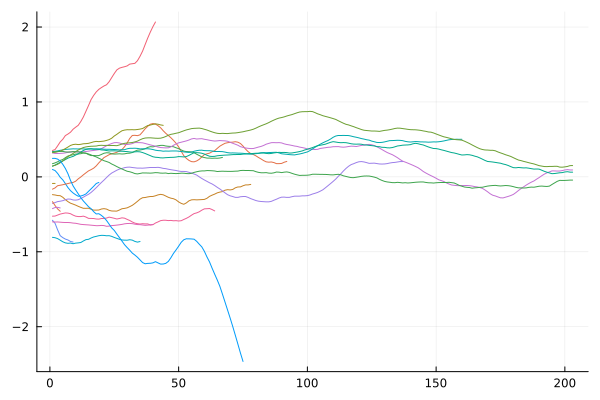

In [15]:
plot(all_y_trajectories, legend=nothing)

In [19]:
values = zeros(Int64, size(scan_values_grid)[2:end])

for (i, s1) ∈ enumerate(s1s)
    for (j, s2) ∈ enumerate(s2s)
        for (k, Δ1) ∈ enumerate(Δ1s)
            for (l, Δ2) ∈ enumerate(Δ2s)
                scan_values = (s1, s2, Δ1, Δ2)
                values[i,j,k,l] = goodness(20e-3, sols, scan_values, scan_values_grid)
            end
        end
    end
end
;

In [20]:
values

3×3×4×4 Array{Int64, 4}:
[:, :, 1, 1] =
 0  0  2
 1  0  3
 0  0  0

[:, :, 2, 1] =
 0  2  0
 1  1  1
 0  0  1

[:, :, 3, 1] =
 1  0  0
 2  1  0
 1  3  1

[:, :, 4, 1] =
 0  0  0
 4  1  0
 1  1  1

[:, :, 1, 2] =
 1  0  2
 1  0  0
 0  0  1

[:, :, 2, 2] =
 3  0  0
 3  1  1
 2  2  0

[:, :, 3, 2] =
 0  0  0
 0  1  0
 1  1  0

[:, :, 4, 2] =
 1  0  0
 0  0  0
 0  1  0

[:, :, 1, 3] =
 1  0  1
 0  0  0
 0  0  0

[:, :, 2, 3] =
 0  0  0
 0  0  1
 0  0  0

[:, :, 3, 3] =
 1  0  0
 0  1  0
 0  0  0

[:, :, 4, 3] =
 0  0  0
 0  0  0
 0  0  0

[:, :, 1, 4] =
 1  1  0
 0  0  1
 1  0  1

[:, :, 2, 4] =
 0  1  1
 0  0  1
 0  0  0

[:, :, 3, 4] =
 0  0  0
 2  0  0
 0  0  1

[:, :, 4, 4] =
 1  1  1
 2  3  3
 2  3  0

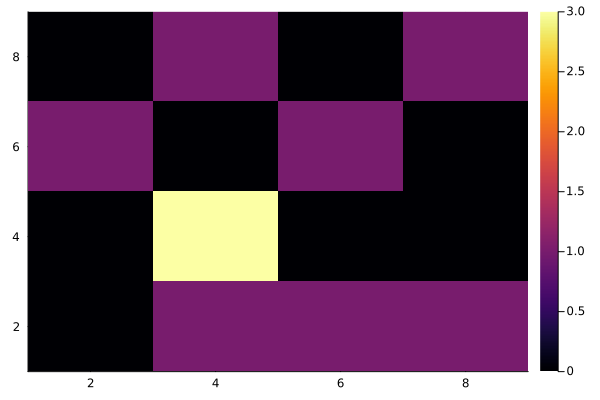

In [21]:
heatmap(Δ1s ./ Γ, Δ2s ./ Γ, values[1,1,:,:])